In [283]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
from mpi4py import MPI
import pickle


# torch
from torch.nn.parameter import Parameter
import torch
import torch.nn as nn
torch.autograd.set_detect_anomaly(False)

# quimb
import quimb as qu
import quimb.tensor as qtn
import autoray as ar
from autoray import do

# from vmc_torch.experiment.tn_model import *
from vmc_torch.sampler import MetropolisExchangeSamplerSpinful
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import SGD, SignedSGD, SignedRandomSGD, SR, TrivialPreconditioner, Adam, SGD_momentum, DecayScheduler
from vmc_torch.VMC import VMC
# from vmc_torch.hamiltonian import spinful_Fermi_Hubbard_square_lattice
from vmc_torch.hamiltonian_torch import spinful_Fermi_Hubbard_square_lattice_torch
from vmc_torch.torch_utils import SVD,QR
from vmc_torch.fermion_utils import generate_random_fpeps
from vmc_torch.utils import closest_divisible

# # Register safe SVD and QR functions to torch
# ar.register_function('torch','linalg.svd',SVD.apply)
# ar.register_function('torch','linalg.qr',QR.apply)

from vmc_torch.global_var import DEBUG


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
Lx = int(4)
Ly = int(4)
symmetry = 'Z2'
t = 1.0
U = 8.0
N_f = int(Lx*Ly-2)
# N_f=12
n_fermions_per_spin = (N_f//2, N_f//2)
H = spinful_Fermi_Hubbard_square_lattice_torch(Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
graph = H.graph
# TN parameters
D = 4
chi = 16
dtype=torch.float64

# Load PEPS
try:
    skeleton = pickle.load(open(f"../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl", "rb"))
    peps_params = pickle.load(open(f"../../data/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl", "rb"))
    peps = qtn.unpack(peps_params, skeleton)
except:
    peps = generate_random_fpeps(Lx, Ly, D=D, seed=2, symmetry=symmetry, Nf=N_f, spinless=False)[0]
peps_np = peps.copy()
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=dtype))
for ts in peps.tensors:
    ts.data.phase_sync(inplace=True)

# VMC sample size
N_samples = 2
N_samples = closest_divisible(N_samples, SIZE)

from fermion_compress import *

In [284]:
random_x = torch.tensor(H.hilbert.random_state())
# random_x = torch.tensor([0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0])
print("random_x:", random_x)

random_x: tensor([2, 3, 3, 0, 0, 2, 3, 1, 0, 2, 3, 0, 0, 1, 0, 1])


tensor(2876.5611, dtype=torch.float64) tensor(2876.5611, dtype=torch.float64)


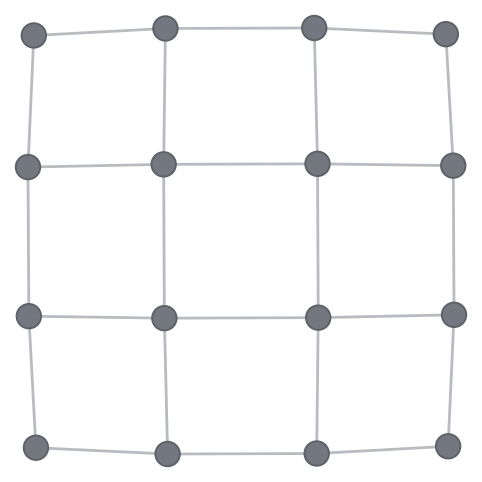

In [285]:
amp0 = peps.get_amp(random_x)
for ts in amp0.tensors:
    ts.data.phase_sync(inplace=True)
amp1 = amp0.contract_boundary_from_xmin(xrange=(0, 1), max_bond=16, cutoff=0.0, mode='zipup', sweep_reverse=False)
benchmark_amp = amp0.contract()
print(amp1.contract(), amp0.contract())
amp0.draw()

In [286]:
# peps_norm = peps.make_norm()
# print("peps norm:", peps_norm.contract())
# print(peps_norm.contract_boundary_from_xmin(xrange=(0, 1), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=2).contract())
# print(peps_norm.contract_boundary_from_xmin(xrange=(0, 1), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=1).contract())

In [287]:
row_no = 2
amp_fit = amp0.contract_boundary_from_ymin(yrange=(0, row_no), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=10)
# print(amp_fit.contract())
print(f'boundary fitting from ymin to col {row_no}: amp fit: {amp_fit.contract()}, benchmark amp: {benchmark_amp}')
row_no = 2
amp_fit = amp0.contract_boundary_from_ymin(yrange=(0, row_no), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=13)
# print(amp_fit.contract())
print(f'boundary fitting from ymin to col {row_no}: amp fit: {amp_fit.contract()}, benchmark amp: {benchmark_amp}')

boundary fitting from ymin to col 2: amp fit: 2876.5611111644985, benchmark amp: 2876.561111164497
boundary fitting from ymin to col 2: amp fit: 2876.5611111645026, benchmark amp: 2876.561111164497


In [288]:
row_no = 2
amp_fit = amp0.contract_boundary_from_ymax(yrange=(row_no, Ly-1), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=10)
# print(amp_fit.contract())
print(f'boundary fitting from ymin to col {row_no}: amp fit: {amp_fit.contract()}, benchmark amp: {benchmark_amp}')
row_no = 2
amp_fit = amp0.contract_boundary_from_ymax(yrange=(row_no, Ly-1), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=13)
# print(amp_fit.contract())
print(f'boundary fitting from ymin to col {row_no}: amp fit: {amp_fit.contract()}, benchmark amp: {benchmark_amp}')

boundary fitting from ymin to col 2: amp fit: 2876.561111164521, benchmark amp: 2876.561111164497
boundary fitting from ymin to col 2: amp fit: 2876.5611111645007, benchmark amp: 2876.561111164497


In [289]:
row_no = 2
amp_fit = amp0.contract_boundary_from_xmin(xrange=(0, row_no), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=10)
# print(amp_fit.contract())
print(f'boundary fitting from xmin to row {row_no}: amp fit: {amp_fit.contract()}, benchmark amp: {benchmark_amp}')
row_no = 2
amp_fit = amp0.contract_boundary_from_xmin(xrange=(0, row_no), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=13)
# print(amp_fit.contract())
print(f'boundary fitting from xmin to row {row_no}: amp fit: {amp_fit.contract()}, benchmark amp: {benchmark_amp}')

boundary fitting from xmin to row 2: amp fit: 2876.5611111645208, benchmark amp: 2876.561111164497
boundary fitting from xmin to row 2: amp fit: 2876.561111164514, benchmark amp: 2876.561111164497


In [290]:
row_no = 2
amp_fit = amp0.contract_boundary_from_xmax(xrange=(row_no, Lx-1), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=10)
print(f'boundary fitting from xmax to row {row_no}: amp fit: {amp_fit.contract()}, benchmark amp: {benchmark_amp}')
row_no = 2
amp_fit = amp0.contract_boundary_from_xmax(xrange=(row_no, Lx-1), max_bond=16, cutoff=0.0, mode='fit', tn_fit='zipup', bsz=2, max_iterations=13)
print(f'boundary fitting from xmax to row {row_no}: amp fit: {amp_fit.contract()}, benchmark amp: {benchmark_amp}')
tn_boundary_quimb_fit = amp_fit.select(['X3'])


boundary fitting from xmax to row 2: amp fit: 2876.5611111645158, benchmark amp: 2876.561111164497
boundary fitting from xmax to row 2: amp fit: 2876.5611111645017, benchmark amp: 2876.561111164497


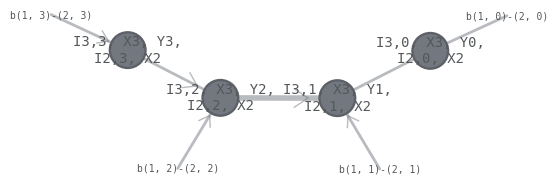

(None,
 FermionicArrayZ2(shape~(4, 4, 4, 4):[----], charge=1, num_blocks=8),
 (True, True, True, True))

In [234]:
tn_boundary_quimb_fit.draw(), tn_boundary_quimb_fit.contract().data, tn_boundary_quimb_fit.contract().data.duals

Contracting I3,0 with I2,0
Contracting I3,1 with I2,1
Contracting I3,2 with I2,2
Contracting I3,3 with I2,3


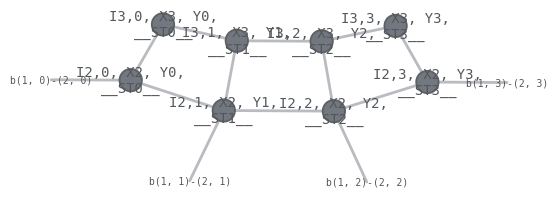

max_tdiff=1.70e+00: 100%|##########| 1/1 [00:00<00:00, 32.25it/s]


compressed_amp: tensor(29460.8417, dtype=torch.float64)
infidelity: tensor(-1.9984e-15, dtype=torch.float64)


In [235]:
record = {}
site_tag_tmps = ['__ST0__', '__ST1__', '__ST2__', '__ST3__']
for j, st in zip(range(Ly), site_tag_tmps):
    tag1 = amp0.site_tag(3, j)
    tag2 = amp0.site_tag(2, j)
    print(f"Contracting {tag1} with {tag2}")
    amp0.add_tag(
        st, where=(tag1, tag2), which="any", record=record
    )

tn_rest_1, tn_boundary = amp0.partition(site_tag_tmps, inplace=False)
tn_boundary.draw()

new_tn_boundary = tensor_network_1d_compress_fit_fermion(
    tn_boundary,
    max_bond=16,
    cutoff=0.0,
    site_tags=site_tag_tmps,
    tn_fit='zipup',
    bsz=2,
    inplace=False,
    max_iterations=1,
    progbar=True
)

tn_rest = tn_rest_1.copy()

tn_rest.add_tensor_network(new_tn_boundary, virtual=True)
print("\ncompressed_amp:", tn_rest.contract())
print('infidelity:', new_tn_boundary.distance(tn_boundary, normalized='infidelity'))

# new_tn_boundary['I0,3'].data.phase_flip(1, inplace=True), new_tn_boundary['I0,2'].data.phase_flip(1, inplace=True)
# print(new_tn_boundary.distance(tn_boundary, normalized='infidelity'))

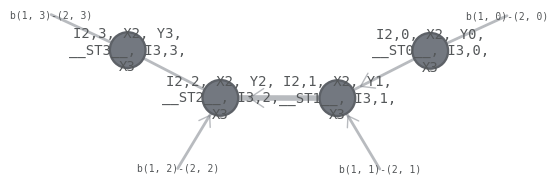

(None,
 FermionicArrayZ2(shape~(4, 4, 4, 4):[----], charge=1, num_blocks=8),
 (-25+, -29+, -38+))

In [33]:
new_tn_boundary.draw(), new_tn_boundary.contract().data, new_tn_boundary.contract().data.oddpos

In [34]:
new_tn_boundary_data = new_tn_boundary.contract().data
new_tn_boundary_data_conj = new_tn_boundary_data.conj(phase_dual=True)
do('tensordot', new_tn_boundary_data, new_tn_boundary_data_conj, axes=([0,1,2,3],[0,1,2,3])), (new_tn_boundary.contract()|new_tn_boundary.conj().contract()).contract()
# BUG: conjugation and contraction do not commute

(tensor(-298777.9620, dtype=torch.float64),
 tensor(-298777.9620, dtype=torch.float64))

In [35]:
new_tn_boundary.conj().contract().inds

('b(1, 3)-(2, 3)', 'b(1, 2)-(2, 2)', 'b(1, 1)-(2, 1)', 'b(1, 0)-(2, 0)')

In [36]:
new_tn_boundary_data.norm()**2

tensor(298777.9620, dtype=torch.float64)

In [37]:
ts1 = new_tn_boundary['I3,3']
ts1_array = ts1.contract().data
# when considering the global oddpos, there should be an extra minus sign
ts1_array.phase_sync(inplace=True)
ts1_array_conj = ts1_array.conj()
for i in range(len(ts1_array_conj.duals)):
    if ts1_array_conj.duals[i]:
        ts1_array_conj.phase_flip(i, inplace=True)

print(ts1_array.norm()**2)
do('tensordot', ts1_array, ts1_array_conj)

tensor(298777.9620, dtype=torch.float64)


tensor(298777.9620, dtype=torch.float64)

In [38]:
amp_fit.select(['X2', 'X3']).distance(new_tn_boundary, normalized='infidelity')

tensor(0.8842, dtype=torch.float64)

In [39]:
(tn_rest_1|new_tn_boundary).contract(), (tn_rest_1|amp_fit.select(['X2', 'X3'])).contract()

(tensor(-40675.8846, dtype=torch.float64),
 tensor(-98130.3705, dtype=torch.float64))

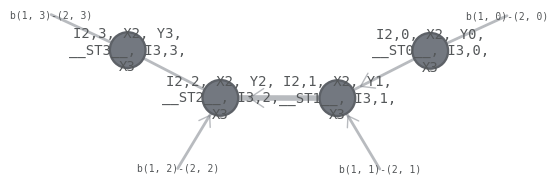

(None, tensor(-298777.9620, dtype=torch.float64))

In [40]:
new_tn_boundary.draw(), (new_tn_boundary|new_tn_boundary.conj()).contract()

In [41]:
new_tn_boundary_ts, row1_zipup_ts = new_tn_boundary.contract(), amp_fit.select(['X2', 'X3']).contract()
new_tn_boundary_ts.data.phase_sync(inplace=True)
row1_zipup_ts.data.phase_sync(inplace=True)

for sec, ts in new_tn_boundary_ts.data.blocks.items():
    print(sec, ts, row1_zipup_ts.data.blocks[sec])

(0, 0, 0, 1) tensor([[[[  85.9917,   19.6979],
          [ -76.7200,    0.1878]],

         [[  97.4083,   11.6818],
          [-184.2274,  -38.6470]]],


        [[[ -71.5756,   -5.1449],
          [  65.3581,   -1.7113]],

         [[ -81.4514,  -12.1814],
          [ 161.0287,   31.2799]]]], dtype=torch.float64) tensor([[[[ -85.9917,  -19.6979],
          [  76.7200,   -0.1878]],

         [[ -97.4083,  -11.6818],
          [ 184.2274,   38.6470]]],


        [[[  71.5756,    5.1449],
          [ -65.3581,    1.7113]],

         [[  81.4514,   12.1814],
          [-161.0287,  -31.2799]]]], dtype=torch.float64)
(1, 0, 1, 1) tensor([[[[-16.8313,  13.1366],
          [ 50.2685,  17.1314]],

         [[-14.1680,   8.8502],
          [ -9.1620,  -1.7315]]],


        [[[ 24.8757,  -9.2192],
          [ 43.1909,   1.3738]],

         [[-26.6207,  29.9571],
          [-77.7212,   4.4003]]]], dtype=torch.float64) tensor([[[[-16.8313,  13.1366],
          [ 50.2685,  17.1314]],

         [[-

In [39]:
ts1 = new_tn_boundary['I0,3']
ts1_array = ts1.contract().data
# ts1_array._charge = 0
# ts1_array._oddpos = {}
# when considering the global oddpos, there should be an extra minus sign
ts1_array.phase_sync(inplace=True)
ts1_array_conj = ts1_array.conj()
for i in range(len(ts1_array_conj.duals)):
    if not ts1_array_conj.duals[i]:
        ts1_array_conj.phase_flip(i, inplace=True)

print(ts1_array.norm()**2)
do('tensordot', ts1_array, ts1_array_conj)

tensor(1233038.9811, dtype=torch.float64)


tensor(1233038.9811, dtype=torch.float64)

In [25]:
new_tn_boundary_ts.data.duals

(False, False, False, False)

In [26]:
new_tn_boundary_ts.inds

('b(1, 3)-(2, 3)', 'b(1, 2)-(2, 2)', 'b(1, 1)-(2, 1)', 'b(1, 0)-(2, 0)')

In [27]:
row1_zipup_ts

Tensor(shape=(4, 4, 4, 4), inds=('b(1, 3)-(2, 3)', 'b(1, 2)-(2, 2)', 'b(1, 1)-(2, 1)', 'b(1, 0)-(2, 0)'), tags=oset(['I0,3', 'X0', 'Y3', 'I1,3', 'X1', 'I0,2', 'Y2', 'I1,2', 'I0,1', 'Y1', 'I1,1', 'I0,0', 'Y0', 'I1,0']))